# Multi-Cell Classification by using Convolution Neural Network

## 2019-19826 한정현


---

## 1. Load Image

First, import libraries and check GPU is available. I use Macbook Air M1, so check mps is available.

In [ ]:
pip install imagecodecs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 14.2 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import pandas as pd
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt

use_gpu = torch.cuda.is_available()
# use_gpu = torch.backends.mps.is_available()
print('GPU available?:', use_gpu)
device = torch.device("cpu")

GPU available?: False


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/My Drive/VGG')

import os
os.chdir('/content/drive/My Drive/VGG')

Mounted at /content/drive


image name: 0.6 con_Plate_R_p00_0_D02f01d0.TIF

* R : raw file
* d0, d2: d0 means nuclei, d2 means cytoplasm

In [ ]:
# image_root = r"0.6 0h con.2023-06-12-05-38-21"
# image_path_nuclei = os.path.join(image_root, r'0.6 con_Plate_R_p00_0_D02f01d0.TIF')
# image_path_cytoplasm = os.path.join(image_root, r'0.6 con_Plate_R_p00_0_D02f01d2.TIF')

# img_pil_nuclei = tiff.imread(image_path_nuclei,key=0)
# img_pil_cytoplasm = tiff.imread(image_path_cytoplasm,key=0)


# tiff.imshow(img_pil_nuclei)
# tiff.imshow(img_pil_cytoplasm)


Lets visualize all cytoplasm images of control, treat

(1536, 2048)


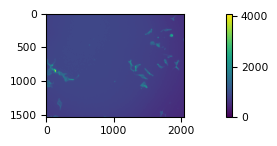

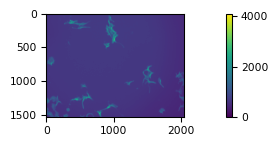

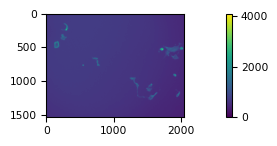

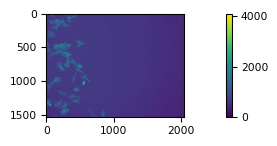

In [ ]:
image_root_control = r"control_cytoplasm"
image_root_treat = r"star_cytoplasm"
image_path_control = os.path.join(image_root_control, r'*.TIF')
image_path_treat = os.path.join(image_root_treat, r'*.TIF')

dirname = r'control_cytoplasm'

def imread_directory(dirname):
  final = []
  for fname in os.listdir(dirname):
      im = tiff.imread(os.path.join(dirname, fname), key=0)
      final.append(im)
  return final


img_tensor_control = imread_directory(image_root_control)
img_tensor_treat = imread_directory(image_root_treat)


idx = 1
for i in img_tensor_control:
  if idx % 10 == 0:
    tiff.imshow(i,subplot=510+(int)(idx/5))
  idx += 1

idx = 1
for i in img_tensor_treat:
  if idx % 10 == 0:
    tiff.imshow(i,subplot=510+(int)(idx/5))
  idx += 1

print(img_tensor_control[0].shape)

---

## 2. PreProcessing Image

* Deprecated process, use "Cellpose" method

The shape of input image is 1536 * 2048, and each pixel value is 0~2^16-1.   
Size of image is too large, so we will devide one image to 48 images which size is 256 * 256 .

In [ ]:
def split_raw_image(image):
  # input image size: (1536, 2048)
  # output image size: 48 images of (256, 256)
  patchs = []
  for j in range(6):
    for k in range(8):
      temp = image[256*j:256*(j+1),256*k:256*(k+1)]
      patchs.append(temp)
  return patchs

In [ ]:
control_images = []
treat_images = []

for i in img_tensor_control:
  control_images.extend(split_raw_image(i))

for i in img_tensor_treat:
  treat_images.extend(split_raw_image(i))

print(len(control_images))
print(len(treat_images))


1248
1248


Next, create dataset of images.    
Make lables of each control and treat images, and concatenate them.   
Make dataset of images and labels.

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split

input_images = torch.Tensor(np.array(control_images + treat_images).astype(np.int16))
print(input_images.shape)

y_control = np.zeros(1248)
y_treat = np.ones(1248)

label = torch.Tensor(np.concatenate([y_control,y_treat]))
print(label.shape)

dataset = TensorDataset(input_images, label)

dataset_size = len(dataset)
print(label)

torch.Size([2496, 256, 256])
torch.Size([2496])
tensor([0., 0., 0.,  ..., 1., 1., 1.])


Normalize images.

In [ ]:
import torchvision.transforms as transforms

mean = [np.mean(x.numpy(), axis=(0,1)) for x,_ in dataset]
std = [np.std(x.numpy(), axis=(0,1)) for x,_ in dataset]

mean = np.mean([m for m in mean])
std = np.mean([m for m in std])

print("mean before normalization: ", mean)
print("std before normalization: ", std)

input_images = (input_images - mean) / std

dataset = TensorDataset(input_images, label)

NameError: ignored

Let’s check whether normalization is done properly.   
Mean should be 0, Std should be 1.

In [ ]:
mean_after_normalization = [np.mean(x.numpy(), axis=(0,1)) for x,_ in dataset]
std_after_normalization = [np.std(x.numpy(), axis=(0,1)) for x,_ in dataset]

mean_after_normalization = np.mean([m for m in mean_after_normalization])
std_after_normalization = np.mean([m for m in std_after_normalization])

print("mean before normalization: ", mean_after_normalization)
print("std before normalization: ", std_after_normalization)

mean before normalization:  1.2226594e-07
std before normalization:  1.0


The most important part is that there are empty images with no cells.   
We need to remove them.   

After checking hundreds of images, I am able to empirically confirm that images with a standard deviation of less than 0.25 were empty images.

So, make mask of images which standard deviation is less than 0.25.

In [ ]:
std_each_image = torch.tensor([np.std(x.numpy(), axis=(0,1)) for x,_ in dataset])
mask = (std_each_image[:] < 0.25)
tmp = dataset[:][0]
no_cell_images = tmp[mask]
print(len(no_cell_images))

680


You can check masking is done properly.

In [ ]:
plt.imshow(no_cell_images[125])

Delete empty images from dataset.

In [ ]:
std_each_image = torch.tensor([np.std(x.numpy(), axis=(0,1)) for x,_ in dataset])
mask = (std_each_image[:] > 0.25)
tmp = dataset[:][0]
filtered_images = tmp[mask]
tmp2 = dataset[:][1]
label = tmp2[mask]

print(len(filtered_images))
dataset_size = len(filtered_images)

dataset = TensorDataset(filtered_images, label)

1816


Split dataset to Train, Validation, Test

In [ ]:
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

Training Data Size : 1452
Validation Data Size : 181
Testing Data Size : 183


Now, make dataloaders of each train, validation, test dataset.

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

##  **Cellpose**

Import cellpose   

I'll use Cellpose 2.0 cytoplasm model

In [ ]:
!pip install cellpose[gui]

import os
os.environ["CELLPOSE_LOCAL_MODELS_PATH"] = "/PATH_FOR_MODELS/"

Using Cellpose 2.0 model, segment individual cells from multi-cell images.  

Segment group "Treat"

In [ ]:
from re import M
from cellpose import models
from cellpose.io import imread


from cellpose import io
from cellpose import plot
from PIL import Image

i=0

image_root_control = r"control"
image_root_treat = r"treat_mix"
image_path_control = os.path.join(image_root_control, r'*.TIF')
image_path_treat = os.path.join(image_root_treat, r'*.TIF')
save_root_treat = r"treat_single"
save_root_control = r"control_single"


dirname = r'control_cytoplasm'

def imread_directory(dirname):
  final = []
  for fname in os.listdir(dirname):
    final.append(os.path.join(dirname, fname))
  return final

img_tensor_control = imread_directory(image_root_control)
img_tensor_treat = imread_directory(image_root_treat)

model = models.Cellpose(gpu=True, model_type='cyto2')


idx = 0
idx2 = 0
for filename in img_tensor_treat:
  img = io.imread(filename)
  img_cyto = img[:,:,0].reshape((1536,2048))
  img_nuclei = img[:,:,2].reshape((1536,2048))
  img_2ch = np.stack([img_cyto,img_nuclei])


  masks, flows, styles, diams = model.eval(img_2ch, diameter = 60, channels=[1,2], flow_threshold=0.5, do_3D=False,resample=True,net_avg = True)

  fig = plt.figure(figsize=(12,5))
  plot.show_segmentation(fig, img_2ch, masks, flows[0], channels=[1,2])
  plt.tight_layout()
  plt.show()


  print(masks.shape)
  mask_max = 0
  for i in masks:
    for j in i:
      if j > mask_max:
        mask_max = j;
  print(mask_max)
  idx = idx + mask_max

  for i in range(mask_max):
    mask_cell = np.zeros((1536,2048))
    cell_coordinates = []
    x = 0
    for row in masks:
      y = 0
      for col in row:
        if col == (i + 1):
          mask_cell[x,y] = img_cyto[x,y]
          cell_coordinates.append([x,y])
        else:
          mask_cell[x,y] = 0
        y = y + 1
      x = x + 1

    min_i ,min_j= np.min(cell_coordinates,axis = 0)
    max_i ,max_j= np.max(cell_coordinates,axis = 0)
    cropped_img = mask_cell[min_i:max_i+1,min_j:max_j+1]

    h, w = cropped_img.shape
    max_wh = np.max([w, h])
    hp = int((max_wh - h) / 2) + 10
    wp = int((max_wh - w) / 2) + 10
    padding = (wp, hp, wp, hp)
    cropped_img = transforms.functional.pad(torch.from_numpy(cropped_img), padding, 0, 'constant')
    cropped_img = transforms.functional.resize(cropped_img.unsqueeze(0), ([256,256])).squeeze(0)
    idx2 = idx2 + 1
    output_path = os.path.join(save_root_treat, f"{idx2}.tiff")
    timage = Image.fromarray(np.uint16(cropped_img.numpy()))
    print(idx2)
    timage.save(output_path, format='TIFF')


Segment group "control"

In [ ]:
image_root_control = r"control_mix"
image_path_control = os.path.join(image_root_control, r'*.TIF')
img_tensor_control = imread_directory(image_root_control)


idx = 0
idx2 = 0
for filename in img_tensor_control:
  img = io.imread(filename)
  img_cyto = img[:,:,0].reshape((1536,2048))
  img_nuclei = img[:,:,2].reshape((1536,2048))
  img_2ch = np.stack([img_cyto,img_nuclei])


  masks, flows, styles, diams = model.eval(img_2ch, diameter = 60, channels=[1,2], flow_threshold=0.5, do_3D=False,resample=True,net_avg = True)

  fig = plt.figure(figsize=(12,5))
  plot.show_segmentation(fig, img_2ch, masks, flows[0], channels=[1,2])
  plt.tight_layout()
  plt.show()


  print(masks.shape)
  mask_max = 0
  for i in masks:
    for j in i:
      if j > mask_max:
        mask_max = j;
  print(mask_max)
  idx = idx + mask_max

  for i in range(mask_max):
    mask_cell = np.zeros((1536,2048))
    cell_coordinates = []
    x = 0
    for row in masks:
      y = 0
      for col in row:
        if col == (i + 1):
          mask_cell[x,y] = img_cyto[x,y]
          cell_coordinates.append([x,y])
        else:
          mask_cell[x,y] = 0
        y = y + 1
      x = x + 1

    min_i ,min_j= np.min(cell_coordinates,axis = 0)
    max_i ,max_j= np.max(cell_coordinates,axis = 0)
    cropped_img = mask_cell[min_i:max_i+1,min_j:max_j+1]

    h, w = cropped_img.shape
    max_wh = np.max([w, h])
    hp = int((max_wh - h) / 2) + 10
    wp = int((max_wh - w) / 2) + 10
    padding = (wp, hp, wp, hp)
    cropped_img = transforms.functional.pad(torch.from_numpy(cropped_img), padding, 0, 'constant')
    cropped_img = transforms.functional.resize(cropped_img.unsqueeze(0), ([256,256])).squeeze(0)
    idx2 = idx2 + 1
    output_path = os.path.join(save_root_control, f"{idx2}.tiff")
    timage = Image.fromarray(np.uint16(cropped_img.numpy()))
    print(idx2)
    timage.save(output_path, format='TIFF')
print(idx)

Each image has a different size.
We design a preprocessing process to make the sizes the same.

1. Use Padding, make image square.
2. Resize the images to 256*256.
3. Normalize.

In [ ]:
class SquarePad:
	def __call__(self, image):
		w, h = image.size
		max_wh = np.max([w, h])
		hp = int((max_wh - w) / 2) + 10
		vp = int((max_wh - h) / 2) + 10
		padding = (hp, vp, hp, vp)
		return transforms.functional.pad(image, padding, 0, 'constant')

# now use it as the replacement of transforms.Pad class
transform=transforms.Compose([
    SquarePad(),
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

Make dataset, split dataset to train/validation/test.

label images. 0: control, 1: treat

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, random_split


image_root_control = r"control_single"
image_root_treat = r"treat_single"
image_path_control = os.path.join(image_root_control, r'*.TIF')
image_path_treat = os.path.join(image_root_treat, r'*.TIF')


control_images = imread_directory(image_root_control)
treat_images = imread_directory(image_root_treat)

print(len(control_images))
print(len(treat_images))


input_images = torch.Tensor(np.array(control_images + treat_images).astype(np.int16))
print(input_images.shape)

y_control = np.zeros(len(control_images))
y_treat = np.ones(len(treat_images))

label = torch.Tensor(np.concatenate([y_control,y_treat]))
print(label.shape)

dataset = TensorDataset(input_images, label)

dataset_size = len(dataset)
print(label)

718
763
torch.Size([1481, 256, 256])
torch.Size([1481])
tensor([0., 0., 0.,  ..., 1., 1., 1.])


In [ ]:
train_size = int(dataset_size * 0.8)
validation_size = int(dataset_size * 0.1)
test_size = dataset_size - train_size - validation_size

train_dataset, validation_dataset, test_dataset = random_split(dataset, [train_size, validation_size, test_size])

print(f"Training Data Size : {len(train_dataset)}")
print(f"Validation Data Size : {len(validation_dataset)}")
print(f"Testing Data Size : {len(test_dataset)}")

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=4, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True, drop_last=True)

Training Data Size : 1184
Validation Data Size : 148
Testing Data Size : 149


---

## 3. Make Model

In [ ]:
BATCH_SIZE=64
num_epochs=5
lr=1e-4
class_size=10

In [ ]:
# VGG type dict
# int : output chnnels after conv layer
# 'M' : max pooling layer
VGG_types = {
    'VGG11' : [64, 'M', 128, 'M', 256, 256, 'M', 512,512, 'M',512,512,'M'],
    'VGG13' : [64,64, 'M', 128, 128, 'M', 256, 256, 'M', 512,512, 'M', 512,512,'M'],
    'VGG16' : [64,64, 'M', 128, 128, 'M', 256, 256,256, 'M', 512,512,512, 'M',512,512,512,'M'],
    'VGG19' : [64,64, 'M', 128, 128, 'M', 256, 256,256,256, 'M', 512,512,512,512, 'M',512,512,512,512,'M']
}

In [ ]:
class VGG16(nn.Module):
  def __init__(self, in_channels=1, num_classes=2, init_weights = True):
    super(VGG16, self).__init__()

    self.in_channels = in_channels

    # create conv_layers corresponding to VGG type
    self.conv_layers = self.create_conv_laters(VGG_types['VGG16'])

    self.fcs = nn.Sequential(
      nn.Linear(512 * 8 * 8, 4096),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(4096, 4096),
      nn.ReLU(),
      nn.Dropout(),
      nn.Linear(4096, num_classes),
    )

    # weight initialization
    if init_weights:
        self._initialize_weights()

  def forward(self, x):
    x = x.to(device)
    x = self.conv_layers(x)
    x = x.view(-1, 512*8*8)
    x = self.fcs(x)
    return x

  # defint weight initialization function
  def _initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight, 0, 0.01)
        nn.init.constant_(m.bias, 0)

  # define a function to create conv layer taken the key of VGG_type dict
  def create_conv_laters(self, architecture):
    layers = []
    in_channels = self.in_channels # 3

    for x in architecture:
      if type(x) == int: # int means conv layer
        out_channels = x

        layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                              kernel_size=(3,3), stride=(1,1), padding=(1,1)),
                    nn.BatchNorm2d(x),
                    nn.ReLU()]
        in_channels = x
      elif x == 'M':
        layers += [nn.MaxPool2d(kernel_size=(2,2), stride=(2,2))]

    return nn.Sequential(*layers)

# create VGGnet object
model = VGG16(in_channels=1, num_classes=2, init_weights=True).to(device)
print(model)

VGG16(
  (conv_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU()
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256, kernel_size=(3, 3), s

In [ ]:
from torchsummary import summary

# print model summary
summary(model, input_size=(1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
       BatchNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
       BatchNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
       BatchNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
      BatchNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

---

## 4. Train Model

In [ ]:
loss_func = nn.CrossEntropyLoss(reduction="mean")
opt = optim.Adam(model.parameters(), lr = 0.0001, weight_decay=1e-5)

# get learning rate
def get_lr(opt):
  for param_group in opt.param_groups:
    return param_group['lr']

current_lr = get_lr(opt)
print('current lr={}'.format(current_lr))

# define learning rate scheduler
# from torch.optim.lr_scheduler import CosineAnnealingLR
# lr_scheduler = CosineAnnealingLR(opt, T_max=2, eta_min=1e-5)

from torch.optim.lr_scheduler import ReduceLROnPlateau
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,
                                                       factor=0.5,
                                                       mode='max',
                                                       verbose=True)


current lr=0.0001


In [ ]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1,keepdim = True)

    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

def loss_batch(loss_func, output, target, opt=None):
    target = target.type(torch.LongTensor).to(device)
    # get loss
    loss = loss_func(output, target)

    # get performance metric
    metric_b = metrics_batch(output,target)

    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

def loss_epoch(model,loss_func,dataset_dl,sanity_check=False,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in dataset_dl:
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)

        # making dimmension (bs, c, h, w)
        bs, h, w = xb.size()
        output_=model(xb.view(bs,1,h,w))
        output = output_


        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)

        # update running loss
        running_loss+=loss_b

        # update running metric
        if metric_b is not None:
            running_metric+=metric_b

        # break the loop in case of sanity check
        if sanity_check is True:
            break

    # average loss value
    loss=running_loss/float(len_data)

    # average metric value
    metric=running_metric/float(len_data)

    return loss, metric

In [ ]:
import time
import copy

def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    sanity_check=params["sanity_check"]
    lr_scheduler=params["lr_scheduler"]
    path2weights=params["path2weights"]

    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }

    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }

    # 가중치를 저장할 때, 코랩 GPU 오류나서 생략했습니다.
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())

    # initialize best loss to a large value
    best_loss=float('inf')

    # main loop
    for epoch in range(num_epochs):
        # check 1 epoch start time
        start_time = time.time()

        # get current learning rate
        current_lr=get_lr(opt)
        print('Epoch {}/{}, current lr={}'.format(epoch, num_epochs - 1, current_lr))

        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,sanity_check,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)

        # evaluate model on validation dataset
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl,sanity_check)


        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())

            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")

        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)

        # learning rate schedule
        lr_scheduler.step(metric_history["val"][-1])

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f, time: %.4f s" %(train_loss,val_loss,100*val_metric, time.time()-start_time))
        print("-"*10)

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, loss_history, metric_history

In [ ]:
# definc the training parameters
params_train = {
    'num_epochs':100,
    'optimizer':opt,
    'loss_func':loss_func,
    'train_dl':train_dataloader,
    'val_dl':validation_dataloader,
    'sanity_check':False,
    'lr_scheduler':lr_scheduler,
    'path2weights':'./models/weights.pt',
}

# create the directory that stores weights.pt
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSerror:
        print('Error')
createFolder('./models')

In [ ]:
# train model
model, loss_hist, metric_hist = train_val(model, params_train)

Epoch 0/99, current lr=0.0001
Copied best model weights!
train loss: 0.092116, dev loss: 0.279969, accuracy: 54.73, time: 4119.2814 s
----------
Epoch 1/99, current lr=0.0001


In [ ]:
model.load_state_dict(torch.load("./models/weights.pt", map_location=device))
model.eval()

In [ ]:
n_correct_control = 0
n_control_total = 0
n_correct_treat = 0
n_treat_total = 0
n_correct = 0
for data in test_dataloader:
    img, label = data
    img = img.type(torch.FloatTensor)
    img = img.view(4,1,256,256)
    # label = label.to(device)
    pred = model(img).to("cpu")
    # print(pred)
    n_control_total += ((label == 0)).sum().item()
    n_treat_total += ((label == 1)).sum().item()

    n_correct += ((pred.argmax(dim=1) == label)).sum().item()
    n_correct_treat += ((pred.argmax(dim=1) == label) & (label == 1)).sum().item()
    n_correct_control += ((pred.argmax(dim=1) == label) & (label == 0)).sum().item()

mask_control = test_dataloader.dataset[:][1] == 0
mask_treat = test_dataloader.dataset[:][1] == 1

print(f"Final Test Accuracy: {n_correct / len(test_dataloader.dataset):.3f}")
print(f"True Control: {n_correct_control / n_control_total:.3f}")
print(f"True Treat: {n_correct_treat / n_treat_total:.3f}")


        # output_=model(xb.view(bs,1,h,w))


---

## 5. Prediction

In [ ]:
test_raw_image_control = tiff.imread(os.path.join(image_root_control, r'0.6 con_Plate_R_p00_0_D02f10d2.TIF'),key=0)
test_raw_image_treat = tiff.imread(os.path.join(image_root_treat, r'0.6 24h con_Plate_R_p00_0_D04f10d2.TIF'),key=0)

test_image_control_raw = split_raw_image(test_raw_image_control)
test_image_treat_raw = split_raw_image(test_raw_image_treat)

test_image_control = (test_image_control_raw  - mean) / std
test_image_treat = (test_image_treat_raw  - mean) / std

# Filter
std_control = torch.tensor([np.std(x, axis=(0,1)) for x in test_image_control])
mask = (std_control[:] > 0.25)
filtered_control = test_image_control[mask]

std_treat = torch.tensor([np.std(x, axis=(0,1)) for x in test_image_treat])
mask = (std_treat[:] > 0.25)
filtered_treat = test_image_treat[mask]

print("number of filtered control: ", len(filtered_control))
print("number of filtered treat: ", len(filtered_treat))

for i in filtered_treat:
  tiff.imshow(i)

In [ ]:
n_correct = 0

for data in filtered_control:
  model.eval()
  img= torch.tensor(np.array(data).astype(np.int16))
  img = img.type(torch.FloatTensor)

  img = img.view(1,1,256,256)
  label = torch.tensor(np.zeros(1))
  pred = model(img).to("cpu")
  print(pred)

  n_correct += (pred.argmax(dim = 1) == label).sum().item()

print(f"Final Test Accuracy: {n_correct / len(filtered_control):.3f}")
        # output_=model(xb.view(bs,1,h,w))

In [ ]:
n_correct = 0

for data in test_image_treat:
  img = torch.tensor(np.array(data).astype(np.int16))
  img = img.type(torch.FloatTensor)

  img = img.view(1,1,256,256)
  label = torch.tensor(np.ones(1))
  pred = model(img).to("cpu")

  n_correct += (pred.argmax(dim = 1) == label).sum().item()

print(f"Final Test Accuracy: {n_correct / len(filtered_treat):.3f}")
        # output_=model(xb.view(bs,1,h,w))

In [ ]:
import gc
gc.collect()
torch.cuda.empty_cache()